In [36]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats
import scipy
from scipy import stats
import datetime
import numpy as np
import seaborn as sns

In [3]:
#API containing spending data on all practices in the 14L(Manchester) CCG
r = requests.get("https://openprescribing.net/api/1.0/spending_by_practice/?code=5.1&org=14L&format=json")
print(r.status_code)

200


In [4]:
#API containing patient size of all practices in the Manchester CCG
r2 = requests.get("https://openprescribing.net/api/1.0/org_details/?org_type=practice&org=14L&keys=total_list_size&format=json")
print(r2.status_code)

200


In [45]:
#converting json files from API into dataframes
df1 = pd.DataFrame(r.json())
df2 = pd.DataFrame(r2.json())

#merging the 2 dataframes
df = pd.merge(df1, df2, how='inner')

#Normalising quantity per 1000 patients
quantity_n = pd.Series(df.quantity/(0.001*df.total_list_size))

#merging normalised quantity into whole dataframe
df = pd.merge(df, quantity_n.rename('quantity_n'), how='inner', left_index=True, right_index=True)
df.head()

,actual_cost,quantity,ccg,row_id,date,items,row_name,setting,total_list_size,quantity_n
0,2856.64,18650,14L,P84004,2014-10-01,417,FIVE OAKS FAMILIY PRACTICE,4,8819,2114.752239
1,919.79,8165,14L,P84005,2014-10-01,203,THE VALLANCE CENTRE,4,7223,1130.416724
2,2063.74,17084,14L,P84009,2014-10-01,357,AILSA CRAIG MEDICAL CENTRE,4,9342,1828.730465
3,1873.21,17154,14L,P84010,2014-10-01,423,THE BORCHARDT MEDICAL CENTRE,4,11108,1544.292402
4,2992.22,28069,14L,P84012,2014-10-01,644,NORTHENDEN GROUP PRACTICE,4,11028,2545.248458


In [90]:
#Subsetting the data by timepoints or by practises using dictionaries
date={}
for i in df.date:
    date[i] = df[df.date == i]
prac={}
for i in df.row_name:
    prac[i] = df.row_name[df.row_name ==i]

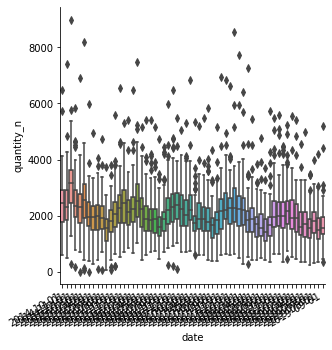

In [72]:
#boxplots of normalised quantity at each timepoint showing outliers
g = sns.catplot(x= 'date', y='quantity_n', data= df, kind = 'box')
g.fig.autofmt_xdate()

In [119]:
#extracting outliers for each time point using matplotlib.cbook's boxplot_stats, and putting it into a list
outliers = []
for i in date:
    outliers.append([y for stat in boxplot_stats(date[i]['quantity_n']) for y in stat['fliers']])

#Above creates a list of lists, this code will flatten this into a flat list
out = []
for sublist in outliers:
    for item in sublist:
        out.append(item)

#print(out, len(out))

In [118]:
#making a dataframe with outlier values removed
df1 = df[~df['quantity_n'].isin(out)]
#print((df.shape, df1.shape))

((5409, 10), (5220, 10))


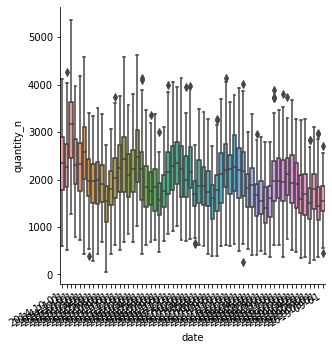

In [112]:
g = sns.catplot(x= 'date', y='quantity_n', data= df1, kind = 'box')
g.fig.autofmt_xdate()

In [114]:
dfstats=df.groupby('date')['quantity_n'].describe().reset_index()
dfstats.head()

,date,count,mean,std,min,25%,50%,75%,max
0,2014-10-01,93.0,2447.704846,960.866716,602.135562,1787.627310,2442.142174,2912.076749,6477.596205
1,2014-11-01,93.0,2421.441774,955.958383,506.035283,1839.802834,2291.818182,2918.446301,7403.795467
2,2014-12-01,93.0,3130.671598,1208.924882,272.980501,2451.834862,3177.286519,3643.458616,8987.348445
3,2015-01-01,92.0,2450.263044,905.538229,175.081056,1946.918689,2332.115512,2900.873214,5845.682041
4,2015-02-01,92.0,2362.611999,896.109804,9.726725,1753.508550,2317.862764,2778.836590,6901.128557


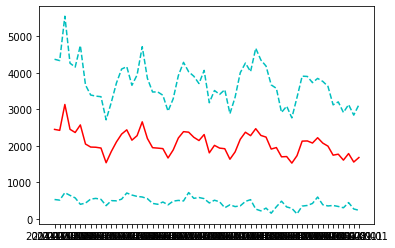

In [35]:
plt.plot(dfstats['date'],dfstats['mean'], '-r', label='mean')
plt.plot(dfstats['date'],dfstats['mean']+ 2*dfstats['std'], '--c')
plt.plot(dfstats['date'],dfstats['mean']- 2*dfstats['std'], '--c')

In [27]:
#x =  np.array(date['2014-10-01']['quantity_n'])
#mean = np.mean(x,axis=0)
#sd = np.std(x,axis=0)
#x_no = [i for i in x if (i > mean - 2*sd)]
#x_no = [i for i in x if (i < mean + 2*sd)]
#print(x_no,len(x_no))
#print(x, len(x))

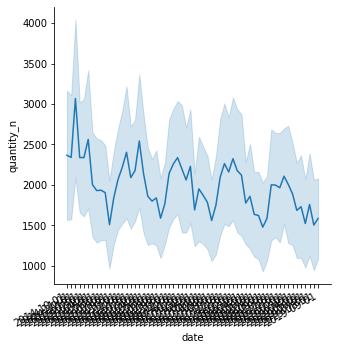

In [110]:
g = sns.relplot(x='date', y='quantity_n', kind='line', ci='sd', data=df1)
g.fig.autofmt_xdate()

In [51]:
df1stats=df1.groupby('date')['quantity_n'].describe().reset_index()
df1stats.head()

,date,count,mean,std,min,25%,50%,75%,max
0,2014-10-01,89.0,2329.333973,765.150449,602.135562,1776.236540,2311.811622,2885.544161,3868.848133
1,2014-11-01,89.0,2299.517057,723.856174,506.035283,1838.192135,2261.936635,2687.331536,3843.575419
2,2014-12-01,78.0,2757.523007,783.167438,272.980501,2349.927705,2805.366709,3365.851327,3942.213298
3,2015-01-01,87.0,2314.156896,712.179989,175.081056,1891.755554,2303.721352,2841.774561,3974.186047
4,2015-02-01,89.0,2271.902895,718.998587,9.726725,1746.875000,2307.380373,2747.578817,3956.744186
